# Pytorch Baseline Model - FasterRCNN


- FasterRCNN from torchvision
- Use Resnet50 backbone
- Albumentation enabled (simple flip for now)


In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import re

from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt

DIR_INPUT = '/kaggle/input/global-wheat-detection'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST = f'{DIR_INPUT}/test'

In [2]:
train_df = pd.read_csv(f'{DIR_INPUT}/train.csv')
train_df.shape

(147793, 5)

In [3]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


#### small test for cv2 library

In [4]:
train_picture1 = cv2.imread(f'{DIR_INPUT}/train/b6ab77fd7.jpg', cv2.IMREAD_COLOR)

In [5]:
cv2.cvtColor(train_picture1, cv2.COLOR_BGR2RGB).astype(np.float32)

array([[[ 26.,  24.,  25.],
        [ 30.,  28.,  29.],
        [ 36.,  34.,  35.],
        ...,
        [ 72.,  97.,  68.],
        [ 74.,  97.,  69.],
        [ 74.,  97.,  68.]],

       [[ 24.,  22.,  23.],
        [ 27.,  25.,  26.],
        [ 33.,  31.,  32.],
        ...,
        [ 68.,  92.,  66.],
        [ 68.,  93.,  64.],
        [ 68.,  93.,  64.]],

       [[ 21.,  19.,  20.],
        [ 24.,  22.,  23.],
        [ 29.,  27.,  28.],
        ...,
        [ 65.,  91.,  66.],
        [ 65.,  91.,  66.],
        [ 65.,  91.,  66.]],

       ...,

       [[ 56.,  56.,  56.],
        [ 56.,  56.,  56.],
        [ 56.,  56.,  56.],
        ...,
        [221., 208., 156.],
        [224., 212., 162.],
        [221., 211., 160.]],

       [[ 60.,  60.,  60.],
        [ 59.,  59.,  59.],
        [ 58.,  58.,  58.],
        ...,
        [201., 188., 135.],
        [206., 194., 142.],
        [209., 199., 146.]],

       [[ 63.,  63.,  63.],
        [ 62.,  62.,  62.],
        [ 61.,  

In [6]:
train_picture1.shape

(1024, 1024, 3)

In [7]:
train_df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [8]:
train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df[['x', 'y', 'w', 'h']] = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = train_df['x'].astype(np.float)
train_df['y'] = train_df['y'].astype(np.float)
train_df['w'] = train_df['w'].astype(np.float)
train_df['h'] = train_df['h'].astype(np.float)

### Select some train example as validation set

There are 3000 training pictures, we select 20% as validation

In [9]:
image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-600:]
train_ids = image_ids[:-600]

In [10]:
valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

In [11]:
valid_df.shape, train_df.shape

((22688, 8), (125105, 8))

When the image file is read with the OpenCV function imread(), the order of colors is BGR (blue, green, red). On the other hand, in Pillow, the order of colors is assumed to be RGB (red, green, blue).

Therefore, if we want to use both the Pillow function and the OpenCV function, you need to convert BGR and RGB.

The only specificity that we require is that the dataset __getitem__ should return:

* image: a PIL Image of size (H, W)

* target: a dict containing the following fields
* boxes (FloatTensor[N, 4]): the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H
* labels (Int64Tensor[N]): the label for each bounding box. 0 represents always the background class.
* image_id (Int64Tensor[1]): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
* area (Tensor[N]): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
* iscrowd (UInt8Tensor[N]): instances with iscrowd=True will be ignored during evaluation.

One note on the labels. The model considers class 0 as background. 

If your dataset does not contain the background class, we should not have 0 in your labels. 

For example, assuming we have just two classes, cat and dog, we can define 1 (not 0) to represent cats and 2 to represent dogs. So, for instance, if one of the images has booth classes, our labels tensor should look like [1,2].

In [12]:
train_df.image_id.unique().shape

(2773,)

In [13]:
class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        # convert BGR to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [14]:
# Albumentations
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


# Create the model

### There are two common situations where one might want to modify one of the available models in torchvision modelzoo. The first is when we want to start from a pre-trained model, and just finetune the last layer. The other is when we want to replace the backbone of the model with a different one (for faster predictions, for example).

## 1. Fine-tune

In [15]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [16]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0


In [17]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

In [18]:
valid_df.head()

,image_id,width,height,source,x,y,w,h
125105,69a211ccf,1024,1024,rres_1,732.0,967.0,84.0,57.0
125106,69a211ccf,1024,1024,rres_1,6.0,777.0,140.0,116.0
125107,69a211ccf,1024,1024,rres_1,269.0,586.0,126.0,103.0
125108,69a211ccf,1024,1024,rres_1,17.0,90.0,84.0,84.0
125109,69a211ccf,1024,1024,rres_1,126.0,98.0,67.0,97.0


In [19]:
valid_dataset[0]

(tensor([[[0.3686, 0.3686, 0.3725,  ..., 0.6275, 0.5765, 0.5451],
          [0.3686, 0.3725, 0.3725,  ..., 0.6118, 0.5765, 0.5529],
          [0.3686, 0.3725, 0.3765,  ..., 0.5804, 0.5569, 0.5451],
          ...,
          [0.2941, 0.2941, 0.2902,  ..., 0.3686, 0.3647, 0.3686],
          [0.2863, 0.2863, 0.2824,  ..., 0.3725, 0.3725, 0.3765],
          [0.2824, 0.2824, 0.2784,  ..., 0.3765, 0.3765, 0.3804]],
 
         [[0.3020, 0.3020, 0.3059,  ..., 0.6627, 0.6196, 0.5882],
          [0.3020, 0.3059, 0.3059,  ..., 0.6471, 0.6196, 0.5961],
          [0.2980, 0.3020, 0.3059,  ..., 0.6157, 0.6000, 0.5882],
          ...,
          [0.2275, 0.2275, 0.2235,  ..., 0.2784, 0.2784, 0.2824],
          [0.2235, 0.2235, 0.2196,  ..., 0.2824, 0.2824, 0.2863],
          [0.2196, 0.2196, 0.2157,  ..., 0.2863, 0.2863, 0.2902]],
 
         [[0.2000, 0.2000, 0.2039,  ..., 0.4784, 0.4510, 0.4196],
          [0.2000, 0.2039, 0.2039,  ..., 0.4706, 0.4510, 0.4275],
          [0.2039, 0.2078, 0.2118,  ...,

In [20]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [21]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
  

# Sample

In [22]:
images, targets, image_ids = next(iter(valid_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [23]:
boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

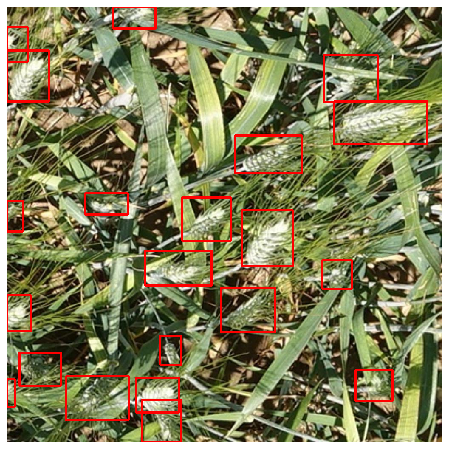

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

# Train

In [25]:
#model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.0005, weight_decay=0.005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
#lr_scheduler = None

num_epochs = 25

In [26]:
def val_metrics(model1, valid_dl):
    model1.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for images_val, targets_val, image_ids_val in valid_dl:
        images = list(image.to(device) for image in images_val)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets_val]

        loss_dict = model1(images, targets)

        print (type(loss_dict))
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

    return loss_value

In [27]:
# total = 0
# sum_loss = 0
# correct = 0 
# for images_val, targets_val, image_ids_val in valid_data_loader:
#     images = list(image.to(device) for image in images_val)
#     targets = [{k: v.to(device) for k, v in t.items()} for t in targets_val]

#     loss_dict = model(images, targets)

#     print (loss_dict)
#     losses = sum(loss for loss in loss_dict.values())
#     loss_value = losses.item()

# print (loss_value)

In [28]:
pre_valid_loss = float("inf")

In [29]:
loss_hist = Averager()
itr = 1

for epoch in range(num_epochs):
    loss_hist.reset()
    
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
        
    
    total = 0
    sum_loss = 0
    correct = 0 
    for images_val, targets_val, image_ids_val in valid_data_loader:
        images_val = list(image.to(device) for image in images_val)
        targets_val = [{k: v.to(device) for k, v in t.items()} for t in targets_val]

        loss_dict_val = model(images_val, targets_val)

        losses_val = sum(loss for loss in loss_dict_val.values())
        val_loss = losses_val.item()
    print("val_loss %.5f"%(val_loss))
    if val_loss < pre_valid_loss:
        pre_valid_loss = val_loss
        torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn_{0:.3f}.pth'.format(val_loss))
    
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")

Iteration #50 loss: 1.1156193017959595
Iteration #100 loss: 0.941298246383667
Iteration #150 loss: 0.8001598119735718
Iteration #200 loss: 0.7347607612609863
Iteration #250 loss: 0.7439019083976746
Iteration #300 loss: 0.5550472140312195
val_loss 0.72347
Epoch #0 loss: 0.9054675090209895
Iteration #350 loss: 0.7233216166496277
Iteration #400 loss: 0.7055473923683167
Iteration #450 loss: 0.6276410818099976
Iteration #500 loss: 0.774703860282898
Iteration #550 loss: 0.7269694805145264
Iteration #600 loss: 0.6918818950653076
Iteration #650 loss: 0.6468921899795532
val_loss 0.64724
Epoch #1 loss: 0.6777550418370052
Iteration #700 loss: 0.7117454409599304
Iteration #750 loss: 0.6575679779052734
Iteration #800 loss: 0.6241264343261719
Iteration #850 loss: 0.7220621109008789
Iteration #900 loss: 0.5748428106307983
Iteration #950 loss: 0.64334636926651
Iteration #1000 loss: 0.6784573793411255
val_loss 0.55222
Epoch #2 loss: 0.6425216989833271
Iteration #1050 loss: 0.6121113300323486
Iteration 

In [30]:
images, targets, image_ids = next(iter(valid_data_loader))

In [31]:
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [32]:
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [33]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

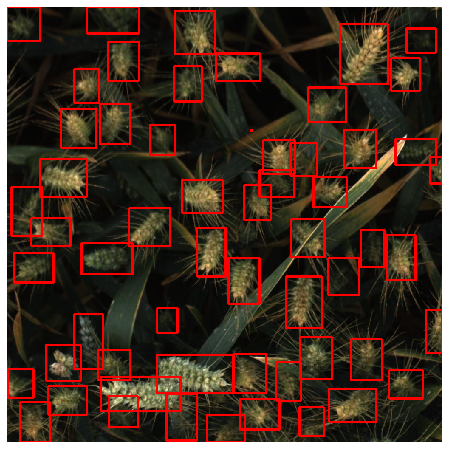

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [35]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

# **References & Credits**

1. TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL

https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html